# Idealized Case 3: Brownian Motion of Cells 

This tutorial shows how tobac can be used to track a large set of Brownian cells. The follwoing chapters will be covered:

1. [Input Data](#1.-Input-Data)
2. [Feature Detection](#2.-Feature-Detection)
3. [Tracking / Trajectory Linking](#3.-Trajectory-Linking)
4. [Segmentation](#4.-Segmentation)
5. [Statistical Analysis](#5.-Statistical-Analysis)

## Imports and Data Creation

In [1]:
import tobac
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import seaborn as sns
from scipy.ndimage import gaussian_filter
from matplotlib.animation import FuncAnimation

sns.set_context("talk")
np.random.seed(12345)

Defining the grid we will work on:

In [2]:
x_min, y_min, x_max, y_max, = 0, 0, 50e-6, 50e-6
t_min, t_max = 0, 100

N_x = 200
N_y = 200
frames = 50

x = np.linspace(x_min, x_max, N_x)
y = np.linspace(y_min, y_max, N_y)
t = np.linspace(t_min, t_max, frames)

yy, xx = np.meshgrid(y, x, indexing='ij')

Brownian cells have temporally and spatially uncorrelated velocities. To simulate this, we create a list of positions iteratively by choosing distances and angles to move froma uniform distribution:

In [3]:
def create_brownian_features(x_0, y_0):
    
    x = x_0
    y = y_0
    
    pos_list = []
    
    for i in range(len(t)):
        ds = np.random.random()*2e-6
        angle = np.random.random()*2*np.pi
        dx = ds*np.cos(angle)
        dy = ds*np.sin(angle)
        x+=dx
        y+=dy
        pos_list.append((x, y))
    
    return np.array(pos_list)

The result plotted on a 2d-domain looks like this:

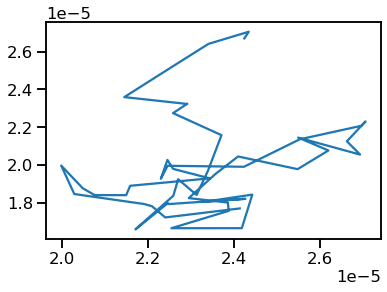

In [4]:
%matplotlib inline

features = create_brownian_features(x_max/2, y_max/2)
plt.plot(features.T[0], features.T[1])

We now need to generate an actual datafield from these positions. The simplest approach is to use our positions as the center of a gaussian and to apply a threshold to create a boolean mask afterwards:

In [5]:
def create_array_from_features(features):
    sigma = 100e-5
    
    data = np.array([np.exp(-((xx-x)**2 + (yy-y)**2)/(2*sigma**4)) for x, y in features])
    return data>0.2

Our brownian cell will look like this:

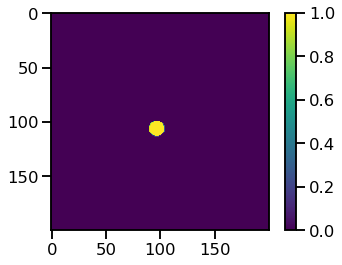

In [6]:
data = create_array_from_features(features)

plt.imshow(data[0])
plt.colorbar()

The last thing we need to do in order to use our data as input for `tobac`, is to convert it to an `xarray`-DataArray. For this we need to set a start time a time delta betwenn our frames. To convention for the names of x- and y-coordinate in `tobac` is 'projection_x_coordinate' resp. 'projection_y_coordinate'.

In [7]:
def create_xarray(array):

    t_0 = np.datetime64('2022-10-01T00:00')
    t_delta = np.timedelta64(100, 'ms')
    time = np.array([t_0 + i*t_delta for i in range(len(array))])
    
    coords = {'time':time,
             'projection_x_coordinate':x,
             'projection_y_coordinate':y
             }
    
    attributes = {'units': ('m s-1')}
    
    data = xr.DataArray(data=array, 
                        coords=coords,  
                        attrs=attributes)
    return data

Let's check our result with an animation:

<IPython.core.display.Javascript object>


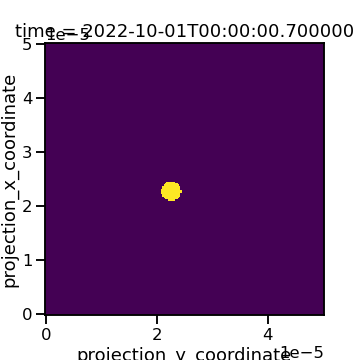

In [8]:
%matplotlib notebook

data = create_xarray(data)

fig, ax = plt.subplots(figsize = (5, 5))

def animate(i):
    data[i].plot.imshow(ax = ax, add_colorbar=False)
    
anim = FuncAnimation(fig, animate, frames = 50)

## Feature detection

Since our cells are trapped in a 2d-domain, they are not able to overlap. So, let's create 50 of those cells following this rule:

In [9]:
N = 0

while N < 40:
    
    if N == 0:
    
        features = create_brownian_features(np.random.random()*x_max, np.random.random()*y_max)
        data = create_array_from_features(features)
        final_data = data
        N += 1
        
    else:
        
        features = create_brownian_features(np.random.random()*x_max, np.random.random()*y_max)
        data = create_array_from_features(features)
        
        if np.all(np.logical_not(np.logical_and(data, final_data))):
        
            final_data = np.logical_or(final_data, data)
            N +=1

final_data = np.array(final_data, dtype='float64')

To make our dataset a little bit emore realistics, we apply a gaussian filter and ad some noise:

In [10]:
data = gaussian_filter(final_data, 0.1)
noise = 0.1 * np.random.randn(*data.shape)

In [11]:
data += noise
data = create_xarray(data)

<IPython.core.display.Javascript object>


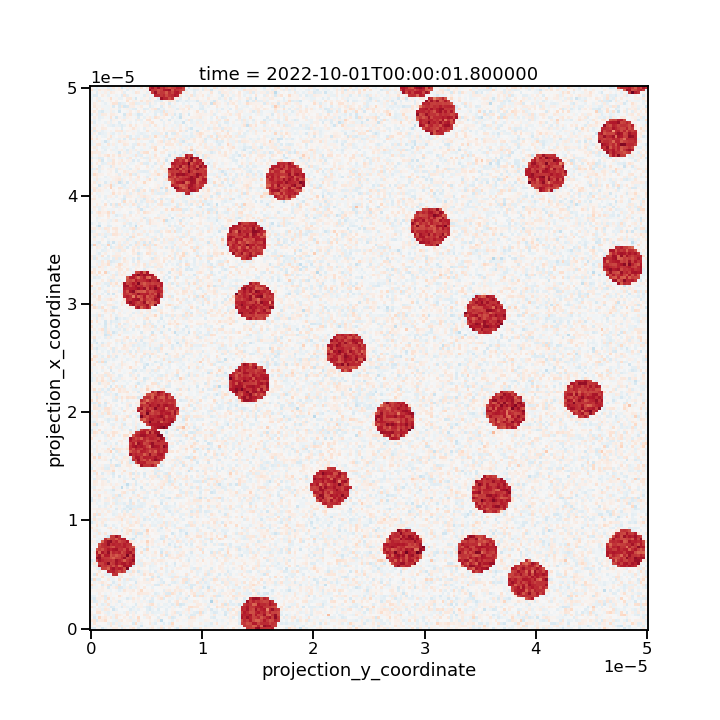

In [12]:
%matplotlib notebook
fig, ax = plt.subplots(figsize = (10, 10))

def animate(i):
    #ax.imshow(data[i])
    data[i].plot.imshow(ax = ax, add_colorbar=False)
    
anim = FuncAnimation(fig, animate, frames = 50)

The first step of our data analysis is to detect the features of our data. 
Additionally we will need to provide the spacing of our grid.

In [25]:
%%capture

dxy, dt = tobac.utils.get_spacings(data, grid_spacing = x_max/N_x)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, 
                                                                  dxy, 
                                                                  n_erosion_threshold=4, 
                                                                  threshold=0.4,
                                                                  sigma_threshold=0.2)

In [26]:
features

<xarray.Dataset>
Dimensions:                  (index: 1442)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 ... 1438 1439 1440 1441
Data variables:
    frame                    (index) int64 0 0 0 0 0 0 0 ... 49 49 49 49 49 49
    idx                      (index) int64 1 2 3 4 5 6 7 ... 19 20 21 22 23 24
    hdim_1                   (index) float64 2.516 3.403 4.717 ... 194.8 196.0
    hdim_2                   (index) float64 68.81 165.6 189.6 ... 125.6 144.8
    num                      (index) int64 62 77 92 84 85 84 ... 84 86 84 84 71
    threshold_value          (index) float64 0.4 0.4 0.4 0.4 ... 0.4 0.4 0.4 0.4
    feature                  (index) int64 1 2 3 4 5 ... 1439 1440 1441 1442
    time                     (index) object 2022-10-01 00:00:00 ... 2022-10-0...
    timestr                  (index) object '2022-10-01 00:00:00' ... '2022-1...
    projection_x_coordinate  (index) float64 6.322e-07 8.549e-07 ... 4.924e-05
    projection_y_coordinate  (index) float64 1.729e-05 4.162e-05 ... 3.639e-05

Frame 49: 24 trajectories present.


Text(0.5, 1.0, 'predict')

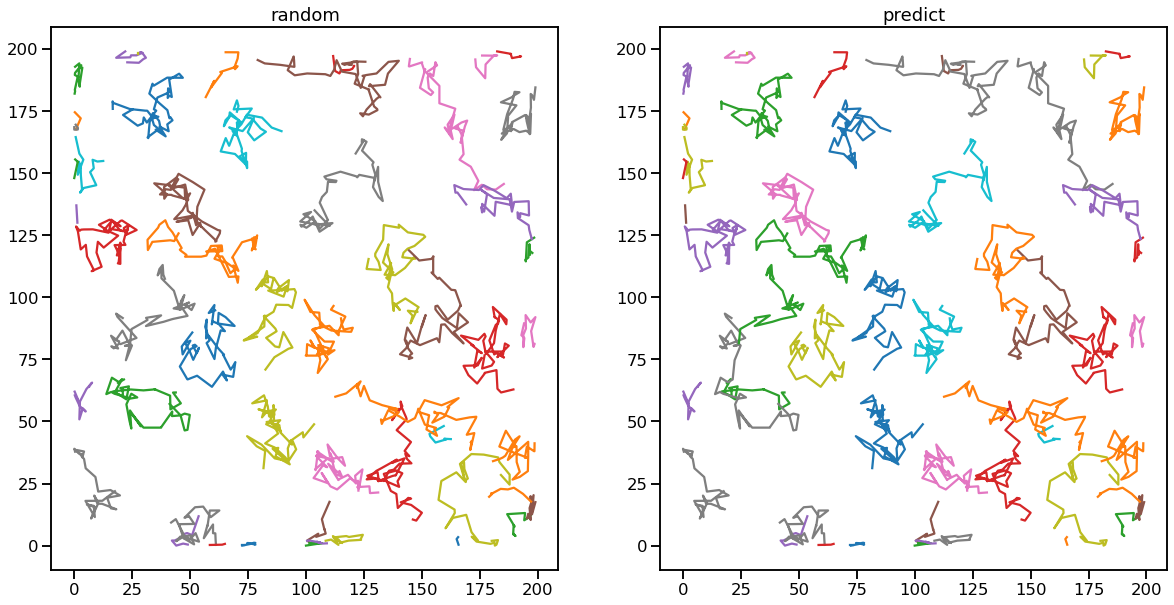

In [27]:
%matplotlib inline


#mask, features = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=0.3)

track1 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=5e-6,
                                              method_linking='random',
                                              subnetwork_size=5)

track2 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=5e-6, 
                                              method_linking='predict',
                                              subnetwork_size=5)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 10))

#ax1.imshow(blob[0], cmap = 'Greys', alpha = 0)
#ax2.imshow(blob[0], cmap = 'Greys', alpha = 0)

"""for i, track_i in track1.groupby('cell'):

    track_i.plot.scatter(
        x="projection_x_coordinate",
        y="projection_y_coordinate",
        ax=ax1,
        marker="x",
        label="cell {0}".format(int(i)),
    ) """
#ax1.legend()
for i, track_i in track1.groupby('cell'):
    ax1.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='',
            linestyle='-')
#ax2.legend()
ax1.set_title('random')

for i, track_i in track2.groupby('cell'):
    ax2.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='',
            linestyle='-')
#ax2.legend()
ax2.set_title('predict')

Text(0.5, 1.0, 'filtered')

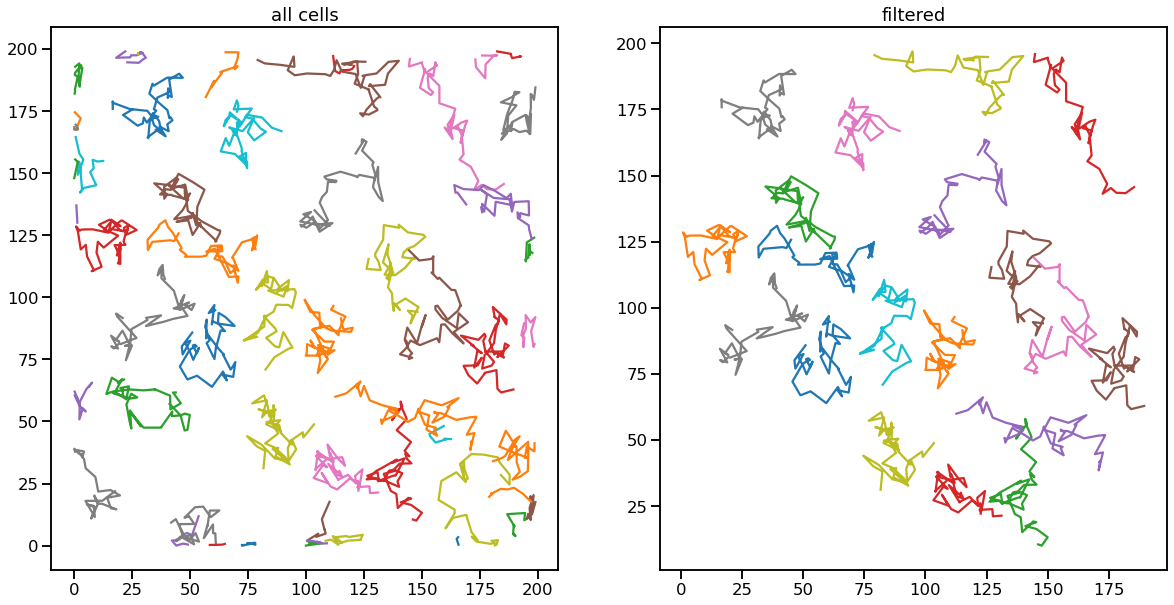

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 10))

for i, track_i in track1.groupby('cell'):
    ax1.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='',
            linestyle='-')
#ax2.legend()
ax1.set_title('all cells')

for i, track_i in track1.groupby('cell'):
    if len(track_i['frame']) == 50:
        ax2.plot(track_i.sortby('frame')['hdim_2'], 
                 track_i.sortby('frame')['hdim_1'],
                label='cell {}'.format(int(i)),
                marker ='',
                linestyle='-')
#ax2.legend()
ax2.set_title('filtered')

In [29]:
n=0
for i, track_i in track1.groupby('cell'):
    if len(track_i['frame']) == 50:
        n +=1
print(n)

19
